In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import pydot
import io

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from sklearn.preprocessing import label_binarize
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

In [2]:
data_new = pd.read_csv('../data/data_all.csv', low_memory=False);

# Create 'year' variable
data_new['YEAR'] = data_new['EXAMDATE'].apply(lambda x: x[:4])

# Subset data to baseline observations for ADNI 1
data_new = data_new.loc[(data_new['VISCODE'] == "bl") & (data_new['ORIGPROT'] == "ADNI1"), :]

In [3]:
data_new.shape

(819, 1465)

# Baseline Model

In [4]:
#Build a baseline model with only known predictors - ex MRI/PET/CSF

#Choose predictors hypothesized as very important for with DX_bl

cols = ["AGE","PTEDUCAT","PTAU_UPENNBIOMK9_04_19_17","ABETA_UPENNBIOMK9_04_19_17", \
        "TAU_UPENNBIOMK9_04_19_17","APOE4","ADAS11"]

y = data_new['DX_bl']
X = data_new[cols]


#Case 1: drop missing values

# get row indices with at least one missing val
#msk = X.apply(lambda x: x.isnull().any(),axis=1) 
#X = X.dropna()
#y = y[~msk]

#Case 2: impute missing values by mean
X = X.fillna(X.mean())

"""
imputer = Imputer(strategy='mean')
for col in X.columns:
    imputed = imputer.fit_transform(X[col].values.reshape(-1,1))
    X.loc[:,col] = imputed
"""

#Case 3: impute via model limputation



"\nimputer = Imputer(strategy='mean')\nfor col in X.columns:\n    imputed = imputer.fit_transform(X[col].values.reshape(-1,1))\n    X.loc[:,col] = imputed\n"

In [5]:
#Check for empty values after imputation
X.apply(lambda x: x.isnull().sum(), axis=0)

AGE                           0
PTEDUCAT                      0
PTAU_UPENNBIOMK9_04_19_17     0
ABETA_UPENNBIOMK9_04_19_17    0
TAU_UPENNBIOMK9_04_19_17      0
APOE4                         0
ADAS11                        0
dtype: int64

In [6]:
np.unique(y,return_counts=True)

(array(['AD', 'CN', 'LMCI'], dtype=object), array([192, 229, 398]))

In [7]:
def confusionMatrixPerClass(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP) 
    FPR = FP/(FP+TN)
    FNR = FN/(TP+FN)
    
    
    result_dict = {"Accuracies": ["True Negative", "False Positive", "False Negative", "True Positive"]}
    result_dict["AD Score"] = [TNR[0], FPR[0], FNR[0], TPR[0]]
    result_dict["CN Score"] = [TNR[1], FPR[1], FNR[1], TPR[1]]
    result_dict["LMCI Score"] = [TNR[2], FPR[2], FNR[2], TPR[2]]

    result_df = pd.DataFrame.from_dict(result_dict).set_index("Accuracies")[['AD Score', "CN Score", "LMCI Score"]]
    return result_df


### Pre-process data 

In [8]:
#method 1 - Build a regularized logistic regression model

#Standardize our variables - we only have continuous variables here in the baseline model
norm_X = (X-X.mean())/X.std()

#Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.33)

#Determine baseline accuracy of various models
baseline_accuracies = {}




In [9]:
models = []
lambdas = [10**x for x in range(-5,6)]

### Multinomial Logistic

In [10]:
multi_logistic = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2', multi_class = 'multinomial')
multi_result = multi_logistic.fit(X_train, y_train)
print("Cross validated parameter for multinomial logistic regression: " + str(multi_result.C_))
print("Multinomial logistic regression training accuracy: ", multi_logistic.score(X_train, y_train))
print("Multinomial logistic regression testing accuracy: ", multi_logistic.score(X_test, y_test))

y_train_predict = multi_result.predict(X_train)
y_test_predict = multi_result.predict(X_test)
baseline_accuracies[str(multi_result.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
models.append(multi_result)
confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))


Cross validated parameter for multinomial logistic regression: [ 1.  1.  1.]
Multinomial logistic regression training accuracy:  0.702554744526
Multinomial logistic regression testing accuracy:  0.660516605166


,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.909091,0.877660,0.634328
False Positive,0.090909,0.122340,0.365672
False Negative,0.411765,0.349398,0.306569
True Positive,0.588235,0.650602,0.693431


### LDA

In [11]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print("LDA Training Score: ", lda.score(X_train, y_train))
print("LDA Testing Score: ",  lda.score(X_test,  y_test))

y_train_predict = lda.predict(X_train)
y_test_predict = lda.predict(X_test)
baseline_accuracies[str(lda.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
models.append(lda)
confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))

LDA Training Score:  0.691605839416
LDA Testing Score:  0.656826568266


,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.890909,0.882979,0.649254
False Positive,0.109091,0.117021,0.350746
False Negative,0.372549,0.349398,0.328467
True Positive,0.627451,0.650602,0.671533


### QDA

In [12]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print("QDA Training Score: ", qda.score(X_train, y_train))
print("QDA Testing Score: ",  qda.score(X_test,  y_test))

y_train_predict = qda.predict(X_train)
y_test_predict = qda.predict(X_test)

baseline_accuracies[str(qda.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
models.append(qda)
confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))

QDA Training Score:  0.662408759124
QDA Testing Score:  0.638376383764


,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.886364,0.819149,0.708955
False Positive,0.113636,0.180851,0.291045
False Negative,0.470588,0.204819,0.416058
True Positive,0.529412,0.795181,0.583942


### KNN

In [13]:
from sklearn.model_selection import KFold

cross_val_n = 1
training_accuracy = 0

X_train_values = X_train.values
for n in range(1, 50):
    neigh = KNeighborsClassifier(n_neighbors=n)
    score = 0
    num_folds = 10
    
    kf = KFold(n_splits = num_folds)

    for train_index, test_index in kf.split(X_train_values):
        X_train_cv, X_val_cv = X_train_values[train_index], X_train_values[test_index]
    
        neigh.fit(X_train_cv, y_train.values[train_index])
        score += neigh.score(X_val_cv, y_train.values[test_index])
        
    score /= num_folds
    print("Average test accuracy for {} nearest neighbors: {}".format(n, score))
    
    if training_accuracy < score:
        training_accuracy = score
        cross_val_n = n

knn_optimal = KNeighborsClassifier(n_neighbors=cross_val_n)
knn_optimal.fit(X_train, y_train)

print("Cross-validated nearest neighbors to use: ", cross_val_n)
print("k-NN Training Score: ", knn_optimal.score(X_train, y_train))
print("k-NN Testing Score: ",  knn_optimal.score(X_test,  y_test))

y_train_predict = knn_optimal.predict(X_train)
y_test_predict = knn_optimal.predict(X_test)

baseline_accuracies[str(knn_optimal.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
models.append(knn_optimal)
confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))

Average test accuracy for 1 nearest neighbors: 0.5476094276094277
Average test accuracy for 2 nearest neighbors: 0.5567003367003368
Average test accuracy for 3 nearest neighbors: 0.5659259259259259
Average test accuracy for 4 nearest neighbors: 0.5676767676767677
Average test accuracy for 5 nearest neighbors: 0.5767003367003367
Average test accuracy for 6 nearest neighbors: 0.5877104377104377
Average test accuracy for 7 nearest neighbors: 0.5768013468013468
Average test accuracy for 8 nearest neighbors: 0.5968686868686868
Average test accuracy for 9 nearest neighbors: 0.5932659932659933
Average test accuracy for 10 nearest neighbors: 0.6096969696969696
Average test accuracy for 11 nearest neighbors: 0.6078787878787879
Average test accuracy for 12 nearest neighbors: 0.6133670033670033
Average test accuracy for 13 nearest neighbors: 0.6023232323232324
Average test accuracy for 14 nearest neighbors: 0.6041750841750841
Average test accuracy for 15 nearest neighbors: 0.6041414141414141
Aver

,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.954545,0.835106,0.597015
False Positive,0.045455,0.164894,0.402985
False Negative,0.568627,0.313253,0.291971
True Positive,0.431373,0.686747,0.708029


### Decison Tree

In [14]:
from sklearn.model_selection import KFold

cross_val_n = 1
training_accuracy = 0
X_train_values = X_train.values
for n in range(2, 15):
    score = 0    
    kf = KFold(n_splits = 5)
    dt = DecisionTreeClassifier(max_depth = n)

    for train_index, test_index in kf.split(X_train_values):
        X_train_cv, X_val_cv = X_train_values[train_index], X_train_values[test_index]        
        dt.fit(X_train_cv, y_train.values[train_index])
        score += dt.score(X_val_cv, y_train.values[test_index])
        
    score /= 5
    print("Average cross-validation test accuracy for depth of {}: {}".format(n, score))
    
    if training_accuracy < score:
        training_accuracy = score
        cross_val_n = n

dt_optimal = DecisionTreeClassifier(max_depth = cross_val_n)
dt_optimal.fit(X_train, y_train)

print("Cross-validated decision tree depth to use: ", cross_val_n)
print("This decision tree has Training Score: ", dt_optimal.score(X_train, y_train))
print("This decision tree has Testing Score: ",  dt_optimal.score(X_test,  y_test))

y_train_predict = dt_optimal.predict(X_train)
y_test_predict = dt_optimal.predict(X_test)

baseline_accuracies[str(dt_optimal.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
models.append(dt_optimal)
confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))

Average cross-validation test accuracy for depth of 2: 0.6770308590492077
Average cross-validation test accuracy for depth of 3: 0.6661551292743954
Average cross-validation test accuracy for depth of 4: 0.6587656380316931
Average cross-validation test accuracy for depth of 5: 0.6497080900750626
Average cross-validation test accuracy for depth of 6: 0.6223185988323603
Average cross-validation test accuracy for depth of 7: 0.6113928273561301
Average cross-validation test accuracy for depth of 8: 0.5913261050875729
Average cross-validation test accuracy for depth of 9: 0.6004837364470392
Average cross-validation test accuracy for depth of 10: 0.5931776480400334
Average cross-validation test accuracy for depth of 11: 0.6041701417848208
Average cross-validation test accuracy for depth of 12: 0.5895913261050876
Average cross-validation test accuracy for depth of 13: 0.5676563803169307
Average cross-validation test accuracy for depth of 14: 0.571326105087573
Cross-validated decision tree dept

,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.890909,0.968085,0.462687
False Positive,0.109091,0.031915,0.537313
False Negative,0.352941,0.650602,0.218978
True Positive,0.647059,0.349398,0.781022


### Random Forest

In [15]:
from sklearn.model_selection import KFold

cross_val_n = 1
training_accuracy = 0
X_train_values = X_train.values

num_trees = [2**x for x in range(1,9)]

for n in num_trees:
    # default gives the required number of predictors (square root of total)
    score = 0    
    kf = KFold(n_splits = 5)
    rf = RandomForestClassifier(n_estimators=n, max_features='sqrt')

    for train_index, test_index in kf.split(X_train_values):
        X_train_cv, X_val_cv = X_train_values[train_index], X_train_values[test_index]        
        rf.fit(X_train_cv, y_train.values[train_index])
        score += rf.score(X_val_cv, y_train.values[test_index])
        
    score /= 5
    print("Average cross-validation test accuracy for trees of {}: {}".format(n, score))
    
    if training_accuracy < score:
        training_accuracy = score
        cross_val_n = n

rf_optimal = RandomForestClassifier(n_estimators = cross_val_n, max_features='sqrt')
rf_optimal.fit(X_train, y_train)

print("Cross-validated decision tree depth to use: ", cross_val_n)
print("This decision tree has Training Score: ", rf_optimal.score(X_train, y_train))
print("This decision tree has Testing Score: ",  rf_optimal.score(X_test,  y_test))

y_train_predict = rf_optimal.predict(X_train)
y_test_predict = rf_optimal.predict(X_test)

baseline_accuracies[str(rf_optimal.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
models.append(rf_optimal)
confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))

Average cross-validation test accuracy for trees of 2: 0.5309924937447873
Average cross-validation test accuracy for trees of 4: 0.5821351125938283
Average cross-validation test accuracy for trees of 8: 0.625838198498749
Average cross-validation test accuracy for trees of 16: 0.6150625521267723
Average cross-validation test accuracy for trees of 32: 0.6332610508757297
Average cross-validation test accuracy for trees of 64: 0.6422852376980818
Average cross-validation test accuracy for trees of 128: 0.6441534612176814
Average cross-validation test accuracy for trees of 256: 0.6478065054211843
Cross-validated decision tree depth to use:  256
This decision tree has Training Score:  1.0
This decision tree has Testing Score:  0.619926199262


,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.868182,0.882979,0.611940
False Positive,0.131818,0.117021,0.388060
False Negative,0.372549,0.421687,0.357664
True Positive,0.627451,0.578313,0.642336


### ADA

In [16]:
from sklearn.model_selection import KFold

cross_val_n = 1
training_accuracy = 0
X_train_values = X_train.values

num_trees = [2**x for x in range(1,9)]

for n in num_trees:
    # default gives the required number of predictors (square root of total)
    score = 0    
    kf = KFold(n_splits = 5)
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,criterion = 'gini'),n_estimators=n)

    for train_index, test_index in kf.split(X_train_values):
        X_train_cv, X_val_cv = X_train_values[train_index], X_train_values[test_index]        
        ada.fit(X_train_cv, y_train.values[train_index])
        score += ada.score(X_val_cv, y_train.values[test_index])
        
    score /= 5
    print("Average cross-validation test accuracy for trees of {}: {}".format(n, score))
    
    if training_accuracy < score:
        training_accuracy = score
        cross_val_n = n

ada_optimal = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,criterion = 'gini'),n_estimators=cross_val_n)
ada_optimal.fit(X_train, y_train)

print("Cross-validated decision tree depth to use: ", cross_val_n)
print("This decision tree has Training Score: ", ada_optimal.score(X_train, y_train))
print("This decision tree has Testing Score: ",  ada_optimal.score(X_test,  y_test))

y_train_predict = ada_optimal.predict(X_train)
y_test_predict = ada_optimal.predict(X_test)

baseline_accuracies[str(ada_optimal.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
models.append(ada_optimal)
confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))

Average cross-validation test accuracy for trees of 2: 0.6570141784820684
Average cross-validation test accuracy for trees of 4: 0.6496914095079233
Average cross-validation test accuracy for trees of 8: 0.6096413678065055
Average cross-validation test accuracy for trees of 16: 0.5729941618015013
Average cross-validation test accuracy for trees of 32: 0.6095579649708089
Average cross-validation test accuracy for trees of 64: 0.6040033361134278
Average cross-validation test accuracy for trees of 128: 0.5602502085070893
Average cross-validation test accuracy for trees of 256: 0.600417014178482
Cross-validated decision tree depth to use:  2
This decision tree has Training Score:  0.644160583942
This decision tree has Testing Score:  0.59778597786


,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.831818,0.968085,0.507463
False Positive,0.168182,0.031915,0.492537
False Negative,0.235294,0.650602,0.313869
True Positive,0.764706,0.349398,0.686131


### SVM

In [17]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

print("SVM Training Score: ", svm_model.score(X_train, y_train))
print("SVM Testing Score: ",  svm_model.score(X_test,  y_test))

y_train_predict = svm_model.predict(X_train)
y_test_predict = svm_model.predict(X_test)

baseline_accuracies[str(svm_model.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
#NOTE: Computing ROC for SVM is too computationally expensive so we add it later
#models.append(svm_model)

confusionMatrixPerClass(metrics.confusion_matrix(y_test, y_test_predict))


SVM Training Score:  0.704379562044
SVM Testing Score:  0.667896678967


,AD Score,CN Score,LMCI Score
Accuracies,,,
True Negative,0.918182,0.877660,0.634328
False Positive,0.081818,0.122340,0.365672
False Negative,0.411765,0.349398,0.291971
True Positive,0.588235,0.650602,0.708029


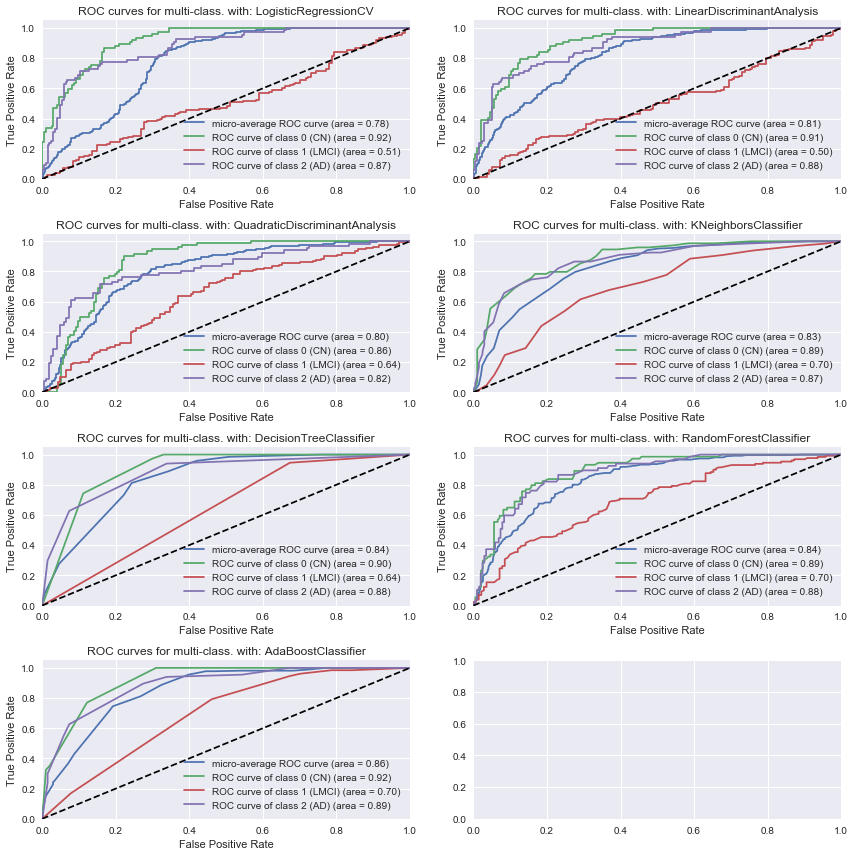

In [18]:
#Plotting ROC Curves for Multi-Classification problem

#reload y and nromalize X
y = data_new['DX_bl']

# Binarize the output
y = label_binarize(y, classes=['CN','LMCI','AD'])
n_classes = y.shape[1]

random_state = 0 

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.33
                                                    ,random_state=0)

fig, axes = plt.subplots(4, 2, figsize=(12, 12))
ax = axes.ravel()

for index,model in enumerate(models):

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)

    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve

    ax[index].plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i,label in zip(range(n_classes),['CN','LMCI','AD']):
        ax[index].plot(fpr[i], tpr[i], label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
                                       ''.format(i,label, roc_auc[i]));

    ax[index].plot([0, 1], [0, 1], 'k--');
    ax[index].set_xlim([0.0, 1.0])
    ax[index].set_ylim([0.0, 1.05])
    ax[index].set_xlabel('False Positive Rate')
    ax[index].set_ylabel('True Positive Rate')
    ax[index].set_title('ROC curves for multi-class. with: {0}'.format(str(model.__class__).split('.')[-1].strip("'>")))
    ax[index].legend(loc="lower right");
    
plt.tight_layout()

In [19]:
models.append(svm_model)

#Now, build a model which has ALL predictors

y = data_new['DX_bl']
X = data_new.copy(deep=True).drop('DX_bl',axis=1)

#Case 2: impute missing values by mean
X = X.fillna(X.mean())

#do not standardize now?
#norm_X = (X-X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.33)

#Determine baseline accuracy of various models
accuracies_all_f = {}
for model in models:
    #log_reg = LogisticRegressionCV(penalty='l2',fit_intercept=True)
    model.fit(X_train,y_train)

    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    #print("Accuracy score of the {} on the training set: {:.5f}" .format(str(model.__class__).split('.')[-1].strip("'>"),accuracy_score(y_train,y_train_predict)))
    #print("Accuracy score of the {} on the test set: {:.5f}" .format(str(model.__class__).split('.')[-1].strip("'>"),accuracy_score(y_test,y_test_predict)))
    #print("Confusion matrix:")
    #print(metrics.confusion_matrix(y_test, y_test_predict),"\n")
    accuracies_all_f[str(model.__class__).split('.')[-1].strip("'>")]=accuracy_score(y_test,y_test_predict)
    
for key in baseline_accuracies:
    print(key,": difference in accuracy \nwith chosen base predictors minus FULL set of predictors")
    print(baseline_accuracies[key]-accuracies_all_f[key])

LogisticRegressionCV : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.0110701107011
LinearDiscriminantAnalysis : difference in accuracy 
with chosen base predictors minus FULL set of predictors
-0.0147601476015
QuadraticDiscriminantAnalysis : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.0184501845018
KNeighborsClassifier : difference in accuracy 
with chosen base predictors minus FULL set of predictors
-0.0221402214022
DecisionTreeClassifier : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.00369003690037
RandomForestClassifier : difference in accuracy 
with chosen base predictors minus FULL set of predictors
-0.0147601476015
AdaBoostClassifier : difference in accuracy 
with chosen base predictors minus FULL set of predictors
-0.0627306273063
SVC : difference in accuracy 
with chosen base predictors minus FULL set of predictors
0.0221402214022


### Backward Selection 

In [20]:
#### Backward selection 

"""ovr_logistic = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2', multi_class = 'ovr')
ovr_result = ovr_logistic.fit(X_train, y_train)

all_predictors = list(X_train.columns)

predictors = [(all_predictors, ovr_result.score(X_test, y_test))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    scores = []
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = X_train[k_minus_1].values
        X_test = X_test[k_minus_1].values
        
        ovr_logistic = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2', multi_class = 'ovr')
        ovr_result = ovr_logistic.fit(X_train, y_train)

        scores.append(ovr_result.score(X_test, y_test))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmax(scores)]]))
    predictors.append((best_k_minus_1, np.max(scores)))
best_predictor_set_b = sorted(predictors, key=lambda t: t[1])[-1]

X_train = data_train[best_predictor_set_b[0]].values
X_test = data_test[best_predictor_set_b[0]].values  
ovr_logistic.fit(X_train, y_train)

print('best predictor set: {}\nscore: {}\ntest R^2: {}'.format(best_predictor_set_b[0], best_predictor_set_b[1], ovr_logistic.score(X_test, y_test)))
""" 


"ovr_logistic = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2', multi_class = 'ovr')\novr_result = ovr_logistic.fit(X_train, y_train)\n\nall_predictors = list(X_train.columns)\n\npredictors = [(all_predictors, ovr_result.score(X_test, y_test))]\n\nfor k in range(len(all_predictors), 1, -1):\n    best_k_predictors = predictors[-1][0]\n    scores = []\n    for predictor in best_k_predictors:\n        k_minus_1 = list(set(best_k_predictors) - set([predictor]))\n        X_train = X_train[k_minus_1].values\n        X_test = X_test[k_minus_1].values\n        \n        ovr_logistic = LogisticRegressionCV(fit_intercept=True, Cs=lambdas, penalty='l2', multi_class = 'ovr')\n        ovr_result = ovr_logistic.fit(X_train, y_train)\n\n        scores.append(ovr_result.score(X_test, y_test))\n    \n    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmax(scores)]]))\n    predictors.append((best_k_minus_1, np.max(scores)))\nbest_predictor_set_b = sorted(pr

<br>We see that including all predictors compared to just previously selected baseline predictors leads to approximately comparable accuracy across all out-of-the-box models.</br>
<br><b>Let's regularize the three best-performing models to get the baseline models and let's use only the limited set of predictors. </b>

In [21]:
####BASELINE MODELS - SEE BELOW FOR CODE FOR ADA, RF and SVM

cols = ["AGE","PTEDUCAT","PTAU_UPENNBIOMK9_04_19_17","ABETA_UPENNBIOMK9_04_19_17", \
        "TAU_UPENNBIOMK9_04_19_17","APOE4","ADAS11"]

y = data_new['DX_bl']
X = data_new[cols]

#Case 2: impute missing values by mean
X = X.fillna(X.mean())

#Standardize
standard_X = (X-X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(standard_X, y, test_size=0.33)

###############
#NOTE: all models can be adjusted to include polynomial features by changing the features degree
###############

#ADA Boost with Decision tree as a classifier

ADA_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('ADA', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion = 'gini'))
                           )])
ADA_param_grid = [{'ADA__n_estimators': [2, 3, 5, 10,50,100]},
                 {'ADA__base_estimator__max_depth':[2,3,4,5,None]}]


ADA_grid = GridSearchCV(ADA_pipe, param_grid=ADA_param_grid,cv = 5)

ADA_grid.fit(X_train, y_train)

print("Test accuracy achieved with ADA", ADA_grid.score(X_test,y_test))

#RF with optimized meta attributes max_depth and number of trees
RF_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('RF', RandomForestClassifier())
                           ])
RF_param_grid = [{'RF__n_estimators': [2, 3, 5, 10,50,100,150]},
                 {'RF__max_depth':[2,3,4,5,None]}]

RF_grid = GridSearchCV(RF_pipe, param_grid=RF_param_grid,cv = 5)

RF_grid.fit(X_train, y_train)

print("Test accuracy achieved with RF", RF_grid.score(X_test,y_test))

#SVM with optimized meta attributes regularization param C and kernel 

SVM_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('SVM', svm.SVC())
                           ])

SVM_param_grid = [{'SVM__C': np.logspace(-4,3)},
                  {'SVM__kernel':['linear','poly','rbf']},{'SVM__degree':[1,2,3,4]}]

SVM_grid = GridSearchCV(SVM_pipe, param_grid=SVM_param_grid,cv = 5)

SVM_grid.fit(X_train, y_train)

print("Test accuracy achieved with SVM", SVM_grid.score(X_test,y_test))

Test accuracy achieved with ADA 0.549815498155
Test accuracy achieved with RF 0.568265682657
Test accuracy achieved with SVM 0.664206642066


# Selecting Features

In [22]:
#use meta_data file to choose feature categories to add

data_meta = pd.read_csv('../data/metadata_new.csv')

#list of categories
categories = list(np.unique(data_meta.cat))
categories

['CSF',
 'Cognitive tests',
 'Cognitive tests (ADAS)',
 'Demographics / Risk factors',
 'Diagnosis',
 'ID',
 'MRI (Cross-sectional)',
 'MRI (Longitudinal)',
 'MRI measures',
 'PET (AV45 AMYLOID)',
 'PET (FDG)',
 'PET measures',
 'Time']

In [23]:
features = list(data_meta.loc[data_meta.cat.isin(['Demographics / Risk factors','CFS','Cognitive tests',"PET (FDG)","PET (AV45 AMYLOID)",'MRI measures']),'column_name'])

data_meta2 = pd.read_csv('../data/data_summary_ADNI1_all.csv')

reduced_set_features = list(data_meta2.iloc[:,0])

#because the new metadata file does not contain the categories, I do a set intersection
u = set(reduced_set_features).intersection(set(features))

In [24]:
#Now perform sort-of a backwards feature selection

y = data_new['DX_bl']
X = data_new[list(u)]

#Case 2: impute missing values by mean
X = X.fillna(X.mean())

#Standardize
#standard_X = (X-X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(standard_X, y, test_size=0.33)

SVM_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 1, interaction_only=False)), 
                           ('SVM', svm.SVC())
                           ])

SVM_param_grid = [{'SVM__C': np.logspace(-4,3)},
                  {'SVM__kernel':['linear','poly','rbf']},{'SVM__degree':[1,2,3,4]}]

SVM_grid = GridSearchCV(SVM_pipe, param_grid=SVM_param_grid,cv = 5)

SVM_grid.fit(X_train, y_train)

print("Test accuracy achieved with SVM", SVM_grid.score(X_test,y_test))

Test accuracy achieved with SVM 0.719557195572
